In [49]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from conexao_banco_dados_resulth import ConexaoBancoDadosResulth
from repositorio_de_banco import FaturamentoReceber
import numpy as np

In [2]:
with sqlite3.connect("db.areceber.sqlite3") as conn:
    df_pmr_giro = pd.read_sql_query("SELECT * FROM saldos;", conn)
    print(df_pmr_giro)

      id        DATA  REC_VENCIDOS  REC_NVENCIDOS  FATURAMENTO
0      1  2025-06-30     156238.97      546081.88   9572252.18
1      2  2025-07-01     156798.59      556299.54   9591334.18
2      3  2025-07-02     166672.00      559733.34   9596310.11
3      4  2025-07-03     162749.91      554301.68   9605242.11
4      6  2025-07-04     170181.84      553281.68   9602099.61
..   ...         ...           ...            ...          ...
132  134  2026-01-02     149734.75      410063.96  10488812.50
133  135  2026-01-05     167961.56      394705.09  10464980.20
134  136  2026-01-06     150825.06      401839.75  10509881.70
135  137  2026-01-08     133719.94      411773.34  10509338.63
136  138  2026-01-09     143439.54      414465.18  10522717.13

[137 rows x 5 columns]


### Quanto foi faturado a prazo?

In [38]:
# Calcular faturamento a receber por mês/ano
def calcular_faturamento_receber(data_inicial: str, data_final: str) -> pd.DataFrame:
    consulta_faturamento = FaturamentoReceber(
        data_inicial=data_inicial,
        data_final=data_final,
        conexao=ConexaoBancoDadosResulth()
    )
    faturamento_receber = consulta_faturamento.processar_dados_faturamento_a_receber()
    df_faturamento_receber = pd.DataFrame(faturamento_receber, columns=["DT_EMISSAO", "VL_TOTAL"])
    df_faturamento_receber['DT_EMISSAO'] = pd.to_datetime(df_faturamento_receber['DT_EMISSAO'])
    return df_faturamento_receber

In [40]:
df_faturamento_receber = calcular_faturamento_receber("2025-01-01", "2025-12-31")

In [42]:
df_faturamento_receber_2024 = calcular_faturamento_receber("2024-01-01", "2024-12-31")

In [44]:
df_faturamento_receber_2024['MES_ANO'] = df_faturamento_receber_2024['DT_EMISSAO'].dt.to_period('M')
df_agrupado_2024 = df_faturamento_receber_2024.groupby('MES_ANO')['VL_TOTAL'].sum().reset_index()

Faturamento mensal a prazo em 2025

In [54]:
df_faturamento_receber['MES_ANO'] = df_faturamento_receber['DT_EMISSAO'].dt.to_period('M')
df_agrupado_2025 = df_faturamento_receber.groupby('MES_ANO')['VL_TOTAL'].sum().reset_index()


Cálculo da média móvel do faturamento

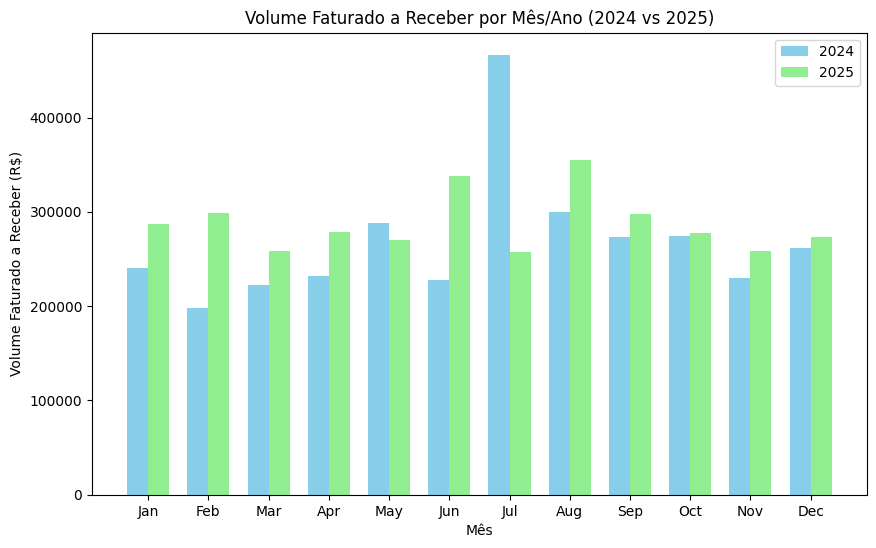

In [52]:
# Plotando o gráfico de barras comparativo 2024 vs 2025
plt.figure(figsize=(10, 6))
bar_width = 0.35
mes = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
x = np.arange(len(mes))

plt.bar(x - bar_width/2, df_agrupado_2024['VL_TOTAL'], width=bar_width, label='2024', color='skyblue')
plt.bar(x + bar_width/2, df_agrupado_2025['VL_TOTAL'], width=bar_width, label='2025', color='lightgreen')
plt.xlabel('Mês')
plt.ylabel('Volume Faturado a Receber (R$)')
plt.title('Volume Faturado a Receber por Mês/Ano (2024 vs 2025)')
plt.xticks(x, mes)
plt.legend()

In [23]:
# Calculo da média móvel de 7 dias
df_faturamento_receber.set_index('DT_EMISSAO', inplace=True)
df_faturamento_receber['VL_TOTAL_MM7'] = df_faturamento_receber['VL_TOTAL'].rolling(window=7).mean()
df_faturamento_receber.reset_index(inplace=True)
df_faturamento_receber.dropna(inplace=True)

df_faturamento_receber

,DT_EMISSAO,VL_TOTAL,VL_TOTAL_MM7,MES_ANO
6,2025-01-16,7386.00,10400.438571,2025-01
7,2025-01-17,15070.01,11207.715714,2025-01
8,2025-01-18,4030.00,10879.572857,2025-01
9,2025-01-20,8620.50,11672.787143,2025-01
10,2025-01-21,15322.00,12635.930000,2025-01
...,...,...,...,...
294,2025-12-26,14457.00,8179.685714,2025-12
295,2025-12-27,6284.00,8838.257143,2025-12
296,2025-12-29,19243.00,11023.257143,2025-12
297,2025-12-30,10050.00,11527.971429,2025-12


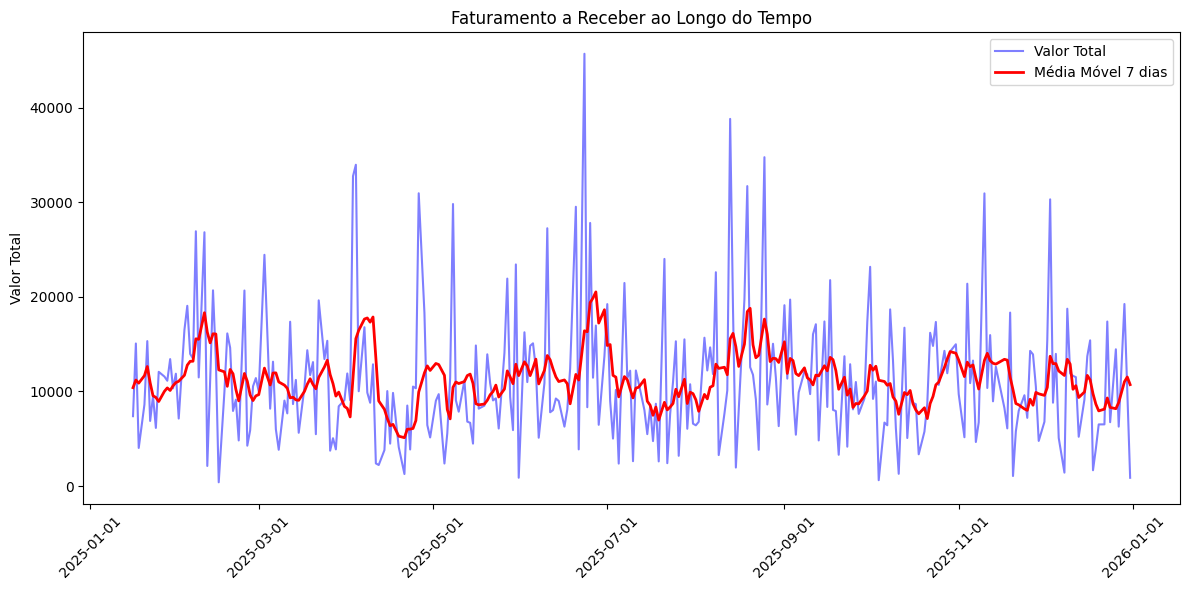

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_faturamento_receber['DT_EMISSAO'], df_faturamento_receber['VL_TOTAL'], label='Valor Total', color='blue', alpha=0.5)
# Plot da média móvel
ax.plot(df_faturamento_receber['DT_EMISSAO'], df_faturamento_receber['VL_TOTAL_MM7'], 
        label='Média Móvel 7 dias', color='red', linewidth=2)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Localizador automático
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato da data
# Rotacionar labels para melhor visualização
plt.title("Faturamento a Receber ao Longo do Tempo")
plt.ylabel("Valor Total")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Estatísticas descritivas do DataFrame
print("Estatísticas Descritivas:")
print(df_faturamento_receber['VL_TOTAL'].describe())

print(f"\nTotal de registros: {len(df_faturamento_receber)}")
print(f"Período: {df_faturamento_receber['DT_EMISSAO'].min()} a {df_faturamento_receber['DT_EMISSAO'].max()}")

# Valores por dia
print("\nTop 10 dias com maior valor total:")
top_dias = df_faturamento_receber.sort_values(by='VL_TOTAL', ascending=False).head(10)
print(top_dias)

Estatísticas Descritivas:
count      299.000000
mean     11276.083579
std       6940.699433
min        400.000000
25%       6558.650000
50%       9996.000000
75%      14259.000000
max      45689.750000
Name: VL_TOTAL, dtype: float64

Total de registros: 299
Período: 2025-01-09 00:00:00 a 2025-12-31 00:00:00

Top 10 dias com maior valor total:
    DT_EMISSAO  VL_TOTAL  VL_TOTAL_MM7
143 2025-06-23  45689.75  16411.092857
187 2025-08-13  38805.80  15562.865714
197 2025-08-25  34758.00  17648.727143
78  2025-04-04  33958.75  15581.678571
77  2025-04-03  32755.00  11453.285714
192 2025-08-19  31703.09  18435.627143
96  2025-04-26  30945.00   9939.362857
262 2025-11-10  30934.00  13287.800000
281 2025-12-03  30303.00  13720.014286
105 2025-05-08  29810.00  10439.558571


Valor recebido dos clientes

In [7]:
# Processar dados faturamento recebido
faturamento_recebido = consulta_faturamento.processar_dados_faturamento_recebido()
df_faturamento_recebido = pd.DataFrame(faturamento_recebido, columns=["DT_EMISSAO", "VL_TOTAL"])
df_faturamento_recebido['DT_EMISSAO'] = pd.to_datetime(df_faturamento_recebido['DT_EMISSAO'])

df_faturamento_recebido

,DT_EMISSAO,VL_TOTAL
0,2025-01-02,6483.79
1,2025-01-03,16491.30
2,2025-01-04,19842.67
3,2025-01-06,9034.50
4,2025-01-07,19106.54
...,...,...
300,2025-12-26,421.00
301,2025-12-27,713.00
302,2025-12-29,2045.00
303,2025-12-30,4204.00


In [8]:
# Estatísticas descritivas do DataFrame
print("Estatísticas Descritivas:")
print(df_faturamento_recebido['VL_TOTAL'].describe())

print(f"\nTotal de registros: {len(df_faturamento_recebido)}")
print(f"Período: {df_faturamento_recebido['DT_EMISSAO'].min()} a {df_faturamento_recebido['DT_EMISSAO'].max()}")

# Valores por dia
print("\nTop 10 dias com maior valor total:")
top_dias = df_faturamento_recebido.sort_values(by='VL_TOTAL', ascending=False).head(10)
print(top_dias)

Estatísticas Descritivas:
count      305.000000
mean      9532.042689
std       6455.548745
min          0.000000
25%       5052.000000
50%       8620.300000
75%      12232.250000
max      36933.900000
Name: VL_TOTAL, dtype: float64

Total de registros: 305
Período: 2025-01-02 00:00:00 a 2025-12-31 00:00:00

Top 10 dias com maior valor total:
    DT_EMISSAO  VL_TOTAL
187 2025-08-13  36933.90
77  2025-04-03  32754.67
96  2025-04-26  30966.50
197 2025-08-25  30629.00
105 2025-05-08  29808.76
141 2025-06-20  29507.60
145 2025-06-25  27788.35
133 2025-06-10  27036.28
31  2025-02-07  26921.50
33  2025-02-10  25836.49


In [9]:
# Cálculo da média móvel de 7 dias
df_faturamento_recebido.set_index('DT_EMISSAO', inplace=True)
df_faturamento_recebido['VL_TOTAL_MM7'] = df_faturamento_recebido['VL_TOTAL'].rolling(window=7).mean()
df_faturamento_recebido.reset_index(inplace=True)
df_faturamento_recebido.dropna(inplace=True)

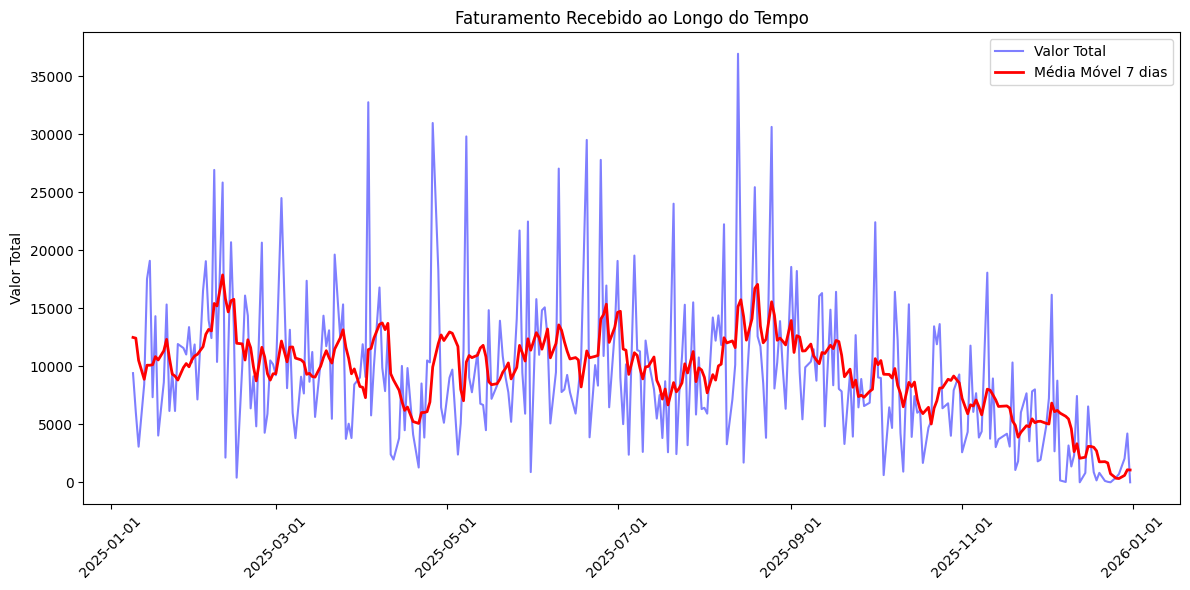

In [10]:
# Gráfico do faturamento recebido ao longo do tempo
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_faturamento_recebido['DT_EMISSAO'], df_faturamento_recebido['VL_TOTAL'], label='Valor Total', color='blue', alpha=0.5)
# Plot da média móvel
ax.plot(df_faturamento_recebido['DT_EMISSAO'], df_faturamento_recebido['VL_TOTAL_MM7'], 
        label='Média Móvel 7 dias', color='red', linewidth=2)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Localizador automático
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato da data
# Rotacionar labels para melhor visualização
plt.title("Faturamento Recebido ao Longo do Tempo")
plt.ylabel("Valor Total")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Dados do Saldo Vencido dos clientes

In [11]:
# Processar dados do saldo vencido
saldo_vencido = consulta_faturamento.processar_dados_saldo_vencido()
df_saldo_vencido = pd.DataFrame(saldo_vencido)
#df_saldo_vencido['DT_EMISSAO'] = pd.to_datetime(df_saldo_vencido['DT_EMISSAO'])

df_saldo_vencido

DatabaseError: ('Cursor.fetchone:\n- SQLCODE: -413\n- conversion error from string "{self.end_date - self.large_day}"', -413, 335544334)